<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/main/Muon%20Beam%20Profile%20Analyzer%20(Curve%20Fitting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:118: SyntaxWarning: invalid escape sequence '\s'
<>:118: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1138617569.py:118: SyntaxWarning: invalid escape sequence '\s'
  print(f"The **Sigma ($\sigma$)** parameter is the standard deviation of the beam intensity profile,")


--- Running SIMULATION 1: Low Noise Analysis ---

--- MUON BEAM PROFILE DIAGNOSTICS (GAUSSIAN FIT) ---
Parameter       | True Value      | Fitted Value        
------------------------------------------------------------
Amplitude       | 100.00          | 99.22 +/- 1.79
Center (mm)     | 5.000           | 5.020 +/- 0.024
Sigma (mm)      | 1.200           | 1.165 +/- 0.024

--- Interpretation ---
The **Sigma ($\sigma$)** parameter is the standard deviation of the beam intensity profile,
directly representing the beam's width and spot size.
The **Center Position** identifies the beam's centroid on the detector.


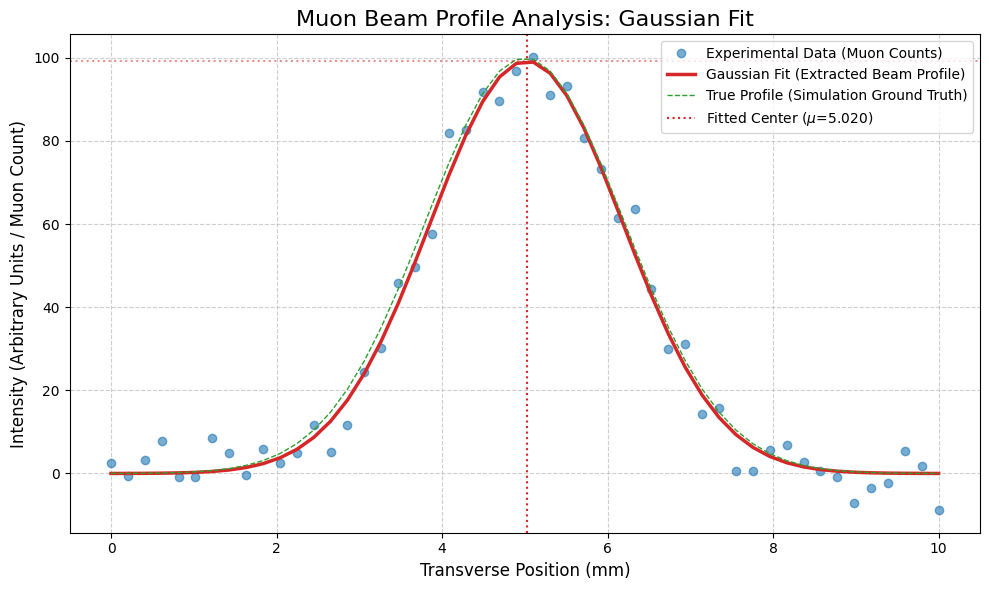


############################################################
--- Running SIMULATION 2: High Noise, Wider Beam Analysis ---
############################################################

--- MUON BEAM PROFILE DIAGNOSTICS (GAUSSIAN FIT) ---
Parameter       | True Value      | Fitted Value        
------------------------------------------------------------
Amplitude       | 150.00          | 140.69 +/- 5.00
Center (mm)     | 4.500           | 4.424 +/- 0.106
Sigma (mm)      | 2.500           | 2.553 +/- 0.116

--- Interpretation ---
The **Sigma ($\sigma$)** parameter is the standard deviation of the beam intensity profile,
directly representing the beam's width and spot size.
The **Center Position** identifies the beam's centroid on the detector.


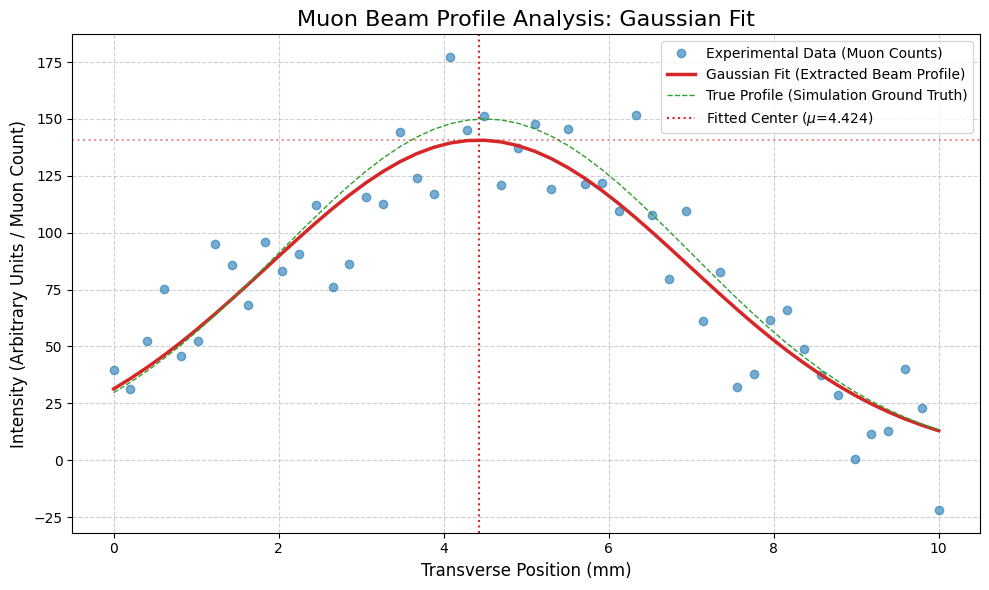

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import logging
from typing import Tuple, Dict, Any

# Configure logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

# ----------------------------------------------------------------------
# 1. Define the Mathematical Model (Gaussian Function)
# ----------------------------------------------------------------------
def gaussian(x: np.ndarray, amplitude: float, center_x: float, sigma: float) -> np.ndarray:
    """
    A 1D Gaussian function used to model a particle beam profile.

    Parameters:
    - x: The position coordinate (e.g., transverse distance in mm).
    - amplitude: The peak intensity of the beam.
    - center_x: The horizontal or vertical center of the beam (mu).
    - sigma: The standard deviation, related to the beam spot size.
    """
    return amplitude * np.exp(-((x - center_x) ** 2) / (2 * sigma ** 2))

# ----------------------------------------------------------------------
# 2. Main Analyzer Class
# ----------------------------------------------------------------------
class BeamProfileAnalyzer:
    """
    Analyzes simulated beam profile data by fitting a Gaussian function
    and reporting the extracted beam parameters.
    """
    def __init__(self, true_amplitude: float, true_center: float, true_sigma: float, noise_level: float, num_points: int = 50):
        self.true_params = {
            'amplitude': true_amplitude,
            'center_x': true_center,
            'sigma': true_sigma
        }
        self.noise_level = noise_level
        self.num_points = num_points
        self.x_data: np.ndarray = np.array([])
        self.y_data: np.ndarray = np.array([])
        self.fitted_params: Dict[str, float] = {}
        self.errors: Dict[str, float] = {}

        self._generate_data()

    def _generate_data(self):
        """Generates the mock experimental data with noise."""
        logging.info("Generating mock beam profile data.")

        # Create measurement points from 0 to 10 mm
        self.x_data = np.linspace(0, 10, self.num_points)

        # Generate the theoretical intensity data using true parameters
        y_theoretical = gaussian(self.x_data, **self.true_params)

        # Add random noise to simulate experimental measurement error
        np.random.seed(42) # Ensure reproducible noise
        self.y_data = y_theoretical + self.noise_level * np.random.normal(size=self.x_data.size)

    def fit_and_analyze(self):
        """Performs the non-linear curve fitting using scipy.optimize.curve_fit."""

        # Set initial guesses for the parameters (critical for good fit convergence)
        initial_guesses = [
            np.max(self.y_data), # Guess for amplitude: Max value in measured data
            np.mean(self.x_data), # Guess for center: Midpoint of the x-range
            1.0                    # Guess for sigma: A reasonable small positive value
        ]

        try:
            # Use curve_fit to find the optimal parameters (popt) and covariance (pcov)
            popt, pcov = curve_fit(gaussian, self.x_data, self.y_data, p0=initial_guesses)

            # Extract the fitted parameters
            self.fitted_params = {
                'amplitude': popt[0],
                'center_x': popt[1],
                'sigma': popt[2]
            }

            # Calculate the standard error (uncertainty) for each parameter
            perr = np.sqrt(np.diag(pcov))
            self.errors = {
                'amplitude': perr[0],
                'center_x': perr[1],
                'sigma': perr[2]
            }
            logging.info("Curve fitting completed successfully.")
            self._display_report()

        except RuntimeError as e:
            logging.error(f"Optimal parameters were not found during fitting: {e}")
            print(f"\nError: Optimal parameters were not found. Check initial guesses or data quality.")
        except Exception as e:
            logging.error(f"An unexpected error occurred during fitting: {e}")

    def _display_report(self):
        """Prints the analysis results and interpretation."""

        if not self.fitted_params:
            return

        print("\n" + "=" * 60)
        print("--- MUON BEAM PROFILE DIAGNOSTICS (GAUSSIAN FIT) ---")
        print("=" * 60)

        # Display True vs. Fitted Parameters
        print(f"{'Parameter':<15} | {'True Value':<15} | {'Fitted Value':<20}")
        print("-" * 60)

        print(f"{'Amplitude':<15} | {self.true_params['amplitude']:<15.2f} | {self.fitted_params['amplitude']:.2f} +/- {self.errors['amplitude']:.2f}")
        print(f"{'Center (mm)':<15} | {self.true_params['center_x']:<15.3f} | {self.fitted_params['center_x']:.3f} +/- {self.errors['center_x']:.3f}")
        print(f"{'Sigma (mm)':<15} | {self.true_params['sigma']:<15.3f} | {self.fitted_params['sigma']:.3f} +/- {self.errors['sigma']:.3f}")

        print("\n--- Interpretation ---")
        print(f"The **Sigma ($\sigma$)** parameter is the standard deviation of the beam intensity profile,")
        print(f"directly representing the beam's width and spot size.")
        print(f"The **Center Position** identifies the beam's centroid on the detector.")

    def plot_results(self):
        """Visualizes the raw data, true curve, and fitted curve."""

        if not self.fitted_params:
            logging.warning("Cannot plot results: fitting was unsuccessful.")
            return

        # Generate y-values for the fitted curve
        y_fitted = gaussian(self.x_data, **self.fitted_params)

        # Generate y-values for the true curve
        y_true = gaussian(self.x_data, **self.true_params)

        fig, ax = plt.subplots(figsize=(10, 6))

        # 1. Plot Raw Experimental Data
        ax.plot(self.x_data, self.y_data, 'o', label='Experimental Data (Muon Counts)', color='#1f77b4', alpha=0.6)

        # 2. Plot Fitted Curve
        ax.plot(self.x_data, y_fitted, '-', label='Gaussian Fit (Extracted Beam Profile)', color='#d62728', linewidth=2.5)

        # 3. Plot True Profile (for comparison, in a real scenario this wouldn't be known)
        ax.plot(self.x_data, y_true, '--', label='True Profile (Simulation Ground Truth)', color='#2ca02c', linewidth=1.0)

        # Add labels and titles
        ax.set_title(r'Muon Beam Profile Analysis: Gaussian Fit', fontsize=16)
        ax.set_xlabel('Transverse Position (mm)', fontsize=12)
        ax.set_ylabel('Intensity (Arbitrary Units / Muon Count)', fontsize=12)

        # Highlight the fitted center and width
        ax.axvline(self.fitted_params['center_x'], color='#d62728', linestyle=':', label=rf'Fitted Center ($\mu$={self.fitted_params["center_x"]:.3f})')
        ax.axhline(self.fitted_params['amplitude'], color='#d62728', linestyle=':', alpha=0.5)

        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        #

# ----------------------------------------------------------------------
# 3. Execution Block (The "Live Always" Simulation)
# ----------------------------------------------------------------------
if __name__ == "__main__":

    # --- SIMULATION 1: LOW NOISE, HIGH PRECISION ---
    print("--- Running SIMULATION 1: Low Noise Analysis ---")
    analyzer1 = BeamProfileAnalyzer(
        true_amplitude=100.0,
        true_center=5.0,
        true_sigma=1.2,
        noise_level=5.0 # Low noise
    )
    analyzer1.fit_and_analyze()
    analyzer1.plot_results()

    # --- SIMULATION 2: HIGH NOISE, WIDER BEAM ---
    print("\n" + "#" * 60)
    print("--- Running SIMULATION 2: High Noise, Wider Beam Analysis ---")
    print("#" * 60)
    analyzer2 = BeamProfileAnalyzer(
        true_amplitude=150.0,
        true_center=4.5,
        true_sigma=2.5, # Wider beam
        noise_level=20.0 # High noise
    )
    analyzer2.fit_and_analyze()
    analyzer2.plot_results()
